
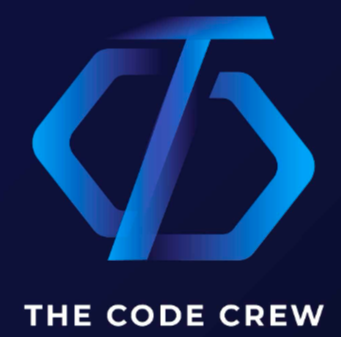


Important Dataframes and files:

- owid-covid-data.csv:This file located in the folder resources contains all the COVID Data downloaded from 
                              <a href="https://github.com/owid/covid-19-data/tree/master/public/data "> Our World in Data </a> 
- clean_covid_data:         Contains only the columns we thing we need from the covid data source csv file
- clean_covid_data_no_date: Similar to clean_covid_data. The Date in this DF now is group by Month and Year and by Country  
- df_clean_data:                 
- gdp_by_year: Iso of the countries and GDP for 2019, 2020, 221    
- covid_and_gdp: Contains a merge between gdp_by_year,df_clean_data on the ISO country
- wbdata: pulls GDP per capita data  from world bank
- delta: Libarry finding the differences between rows

In [ ]:
# Dependencies
from census import Census
import hvplot.pandas
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt
import wbdata
import delta
from datetime import datetime 
import numpy as np 



# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")





In [ ]:
# Importing data from Stats Canada
csv_url = "Resources/owid-covid-data.csv"
covid_data = pd.read_csv(csv_url)
covid_data.columns


In [ ]:
# Filtering DataFrame by columns of interest
clean_covid_data = covid_data.loc[covid_data['iso_code'].str.contains('OWID_')==False, ['iso_code', 'location', 'date', 'new_cases',  'new_deaths',  'new_cases_per_million',  'new_deaths_per_million',
                                      'icu_patients',
                                      'icu_patients_per_million', 'hosp_patients_per_million', 'new_tests_per_thousand',
                                      'positive_rate', 'people_vaccinated_per_hundred',
                                      'people_fully_vaccinated_per_hundred', 'stringency_index',
                                      'population_density', 'median_age',
                                      'gdp_per_capita', 'extreme_poverty', 'human_development_index', 'population']]


# Creating a list of columns to sum and calculate mean

sum_columns_list = ['new_cases',  'new_deaths',
                    'new_cases_per_million',  'new_deaths_per_million']
mean_columns_list = ['icu_patients','icu_patients_per_million','hosp_patients_per_million']                              

# Converting NaN to 0
clean_covid_data = clean_covid_data.fillna(0)

# Display DF
clean_covid_data.head(10)


In [ ]:

# Creating a new column for Month-Year
clean_covid_data.insert(3,"month_year",pd.to_datetime(clean_covid_data['date']).dt.to_period('M') )
clean_covid_data_no_date = clean_covid_data.drop('date',axis = 1)

# Display DF
clean_covid_data_no_date.head(10)

In [ ]:
iso_codes = clean_covid_data_no_date['iso_code'].unique()
iso_codes

In [ ]:
# Creating a DataFrame grouping by Month-Year and Country and adding the columns for sums and average

df_sum = clean_covid_data_no_date.groupby(['iso_code', 'month_year'])[
    sum_columns_list].sum()



df_sum = df_sum.rename(columns={"new_cases":"sum_new_cases",'new_deaths':'sum_new_deaths', 'new_cases_per_million': 'sum_new_cases_per_million'\
                        , 'new_deaths_per_million': 'sum_new_deaths_per_million' })
                      
df_sum=df_sum.reset_index()

df_mean = clean_covid_data_no_date.groupby(['iso_code', 'month_year'])[
    mean_columns_list].mean()

df_mean=df_mean.reset_index()

df_mean = df_mean.rename(columns={'icu_patients': 'average_icu_patients',
                    'icu_patients_per_million': 'average_icu_patients_per_million','hosp_patients_per_million':'average_hosp_patients_per_million'})


df_clean_data = pd.merge(df_sum, df_mean, on=['iso_code', 'month_year'])

df_clean_data



In [ ]:
# Create a DataFrame for Static Columns
totals_list=['stringency_index','population_density', 'median_age',
                                      'gdp_per_capita', 'extreme_poverty', 'human_development_index', 'population']
df_totals = clean_covid_data_no_date.groupby(
    ['iso_code'])[totals_list].mean()

# Converting population to Int
df_totals['population'] = df_totals['population'].astype(int)

df_totals


In [ ]:
wbdata.getGdpData()

In [ ]:
# Creating dataframe from World Bank API JSON
gdp = wbdata.getGdpData()
gdp = [entry for entry in gdp if int(entry['date']) > 2018]
gdp_df = pd.DataFrame.from_dict(gdp)
gdp_by_year = gdp_df[['countryiso3code', 'date', 'value']]
gdp_by_year = gdp_by_year.rename(columns={'countryiso3code': 'iso_code'})

# Fillining NaN with 0
gdp_by_year = gdp_by_year.fillna(0)

# Using .pivot_table
gdp_by_year = gdp_by_year.pivot_table(
    values='value', index='iso_code', columns='date', aggfunc='first')

gdp_by_year = gdp_by_year.reset_index()

gdp_by_year = gdp_by_year[gdp_by_year['iso_code'].isin(iso_codes)]

print(gdp_by_year)

gdp_2019 = gdp_by_year.loc[:,['iso_code', '2019']]
gdp_2019 = gdp_2019.loc[gdp_2019['2019']>0]
# gdp_2019 = gdp_2019.drop(index=0)


gdp_head = gdp_2019.sort_values(by='2019').head()
gdp_tail = gdp_2019.sort_values(by='2019').tail()

countries_selected = pd.concat([gdp_head['iso_code'], gdp_tail['iso_code']])
countries_selected = countries_selected.reset_index(drop=any).tolist()

## Make this into a function to calculate other years


# gdp_tail


In [ ]:
## Combining Covid Data and world bank GDP 



covid_and_gdp= pd.merge(gdp_by_year,df_clean_data, how='inner', on='iso_code')

covid_and_gdp.to_csv("Resources/covid_and_gdp.csv")

covid_and_gdp




In [ ]:
df_clean_data

In [ ]:
#finding the delta in ICU cases in each day. (ICU cases cannot be added.)

delta_clean_covid_data = delta.appendDelta(clean_covid_data)
delta_clean_covid_data.to_csv("Resources/clean_covid_data_icu.csv")

# Histogram of the top and bottom 5 countries against new cases.

In [ ]:
#getting the 5 top and bottom countries 

gdp_top = gdp_2019.sort_values(by='2019').tail(5)
gdp_bottom = gdp_2019.sort_values(by='2019').head()



# Top Countries
top_countries_selected =  gdp_top["iso_code"]
top_countries_selected=top_countries_selected.reset_index(drop=any)
print("\n The top Countries are:")
print(top_countries_selected)



# Bottom Countries
bottom_countries_selected =  gdp_bottom["iso_code"]
bottom_countries_selected=bottom_countries_selected.reset_index(drop=any)
print("\n The top Countries are:")
print(bottom_countries_selected)




In [ ]:


#Making sum_new_cases an integer
df_clean_data["sum_new_cases"] = df_clean_data["sum_new_cases"].astype("int64")
df_clean_data["sum_new_deaths"] = df_clean_data["sum_new_deaths"].astype("int64")
df_clean_data["sum_new_cases_per_million"] = df_clean_data["sum_new_cases_per_million"].astype("int64")
df_clean_data["sum_new_deaths_per_million"] = df_clean_data["sum_new_deaths_per_million"].astype("int64")




top_countries_data = df_clean_data.loc[ (df_clean_data["iso_code"].isin(top_countries_selected)),
                                        # & (df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y')=="2020"),
                                        ["iso_code","month_year","sum_new_cases"]]




# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
top_countries_data.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
top_countries_data.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
top_countries_data["month"] = top_countries_data["month"].astype("int64")
top_countries_data["year"] = top_countries_data["year"].astype("int64")

top_countries_data.reset_index(drop='Any',inplace=True)

top_countries_data =top_countries_data.loc[(top_countries_data["month_year"]!= "2020-02") &
                                     (top_countries_data["month_year"]!= "2020-03") &
                                     (top_countries_data["year"]!= 2023)]


top_countries_data.head()


# top_hist_graph= top_countries_data.plot.bar(x="month_year", y=["sum_new_cases","iso_code"],rot=90,figsize=(20,10))




### Top 5 Countries - New Cases

CYM


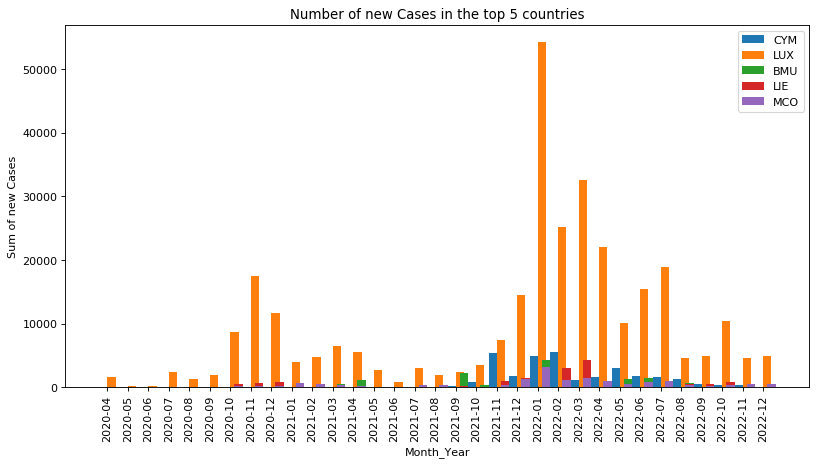

In [24]:
top_countries_data = top_countries_data.reset_index(drop=any)

labelx = []
labelx = top_countries_data["month_year"].unique()


country_1_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[0]),["sum_new_cases"]]
country_2_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[1]),["sum_new_cases"]]
country_3_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[2]),["sum_new_cases"]]
country_4_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[3]),["sum_new_cases"]]
country_5_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[4]),["sum_new_cases"]]


country_1_top_sum_new_cases = country_1_top_sum_new_cases["sum_new_cases"].to_list()
country_2_top_sum_new_cases = country_2_top_sum_new_cases["sum_new_cases"].to_list()
country_3_top_sum_new_cases = country_3_top_sum_new_cases["sum_new_cases"].to_list()
country_4_top_sum_new_cases = country_4_top_sum_new_cases["sum_new_cases"].to_list()
country_5_top_sum_new_cases = country_5_top_sum_new_cases["sum_new_cases"].to_list()

X_axis = np.arange(len(labelx))
print(str(top_countries_selected[0]))

plt.figure(figsize=(12,6), dpi=80) 
plt.bar(X_axis - 0.2, country_1_top_sum_new_cases, 0.4, label = top_countries_selected[0])
plt.bar(X_axis + 0.2, country_2_top_sum_new_cases, 0.4, label = top_countries_selected[1])
plt.bar(X_axis + 0.4, country_3_top_sum_new_cases, 0.4, label = top_countries_selected[2])
plt.bar(X_axis + 0.4, country_4_top_sum_new_cases, 0.4, label = top_countries_selected[3])
plt.bar(X_axis + 0.4, country_5_top_sum_new_cases, 0.4, label = top_countries_selected[4])
  
plt.xticks(X_axis, labelx)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Cases")
plt.title("Number of new Cases in the top 5 countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()




### Bottom 5 Countries - New Cases

In [ ]:


bottom_countries_data = df_clean_data.loc[ (df_clean_data["iso_code"].isin(bottom_countries_selected)),
                                        # & (df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y')=="2020"),
                                        ["iso_code","month_year","sum_new_cases"]]




# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
bottom_countries_data.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
bottom_countries_data.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
bottom_countries_data["month"] = bottom_countries_data["month"].astype("int64")
bottom_countries_data["year"] = bottom_countries_data["year"].astype("int64")

bottom_countries_data.reset_index(drop='Any',inplace=True)

bottom_countries_data =bottom_countries_data.loc[(bottom_countries_data["month_year"]!= "2020-02") &
                                     (bottom_countries_data["month_year"]!= "2020-03") &
                                     (bottom_countries_data["year"]!= 2023)]


bottom_countries_data.head()


BDI


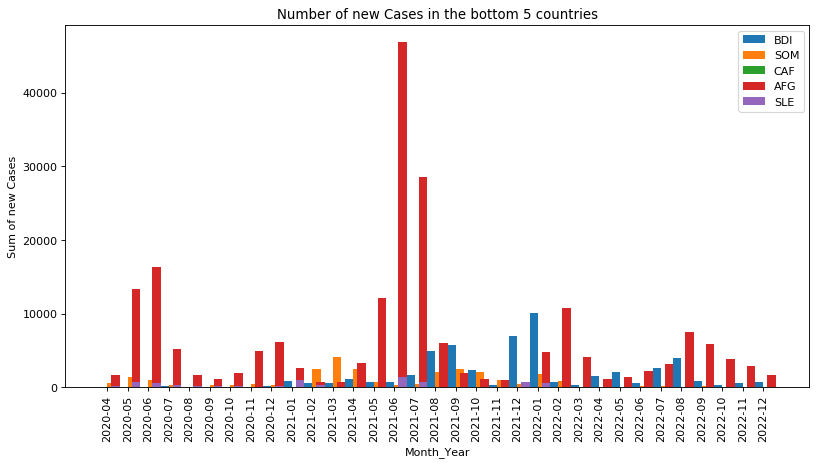

In [25]:
bottom_countries_data = bottom_countries_data.reset_index(drop=any)

labelx_b = []
labelx_b = bottom_countries_data["month_year"].unique()


country_1_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[0]),["sum_new_cases"]]
country_2_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[1]),["sum_new_cases"]]
country_3_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[2]),["sum_new_cases"]]
country_4_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[3]),["sum_new_cases"]]
country_5_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[4]),["sum_new_cases"]]


country_1_bottom_sum_new_cases = country_1_bottom_sum_new_cases["sum_new_cases"].to_list()
country_2_bottom_sum_new_cases = country_2_bottom_sum_new_cases["sum_new_cases"].to_list()
country_3_bottom_sum_new_cases = country_3_bottom_sum_new_cases["sum_new_cases"].to_list()
country_4_bottom_sum_new_cases = country_4_bottom_sum_new_cases["sum_new_cases"].to_list()
country_5_bottom_sum_new_cases = country_5_bottom_sum_new_cases["sum_new_cases"].to_list()

X_axis = np.arange(len(labelx_b))
print(str(bottom_countries_selected[0]))

plt.figure(figsize=(12,6), dpi=80) 
plt.bar(X_axis - 0.2, country_1_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[0])
plt.bar(X_axis + 0.2, country_2_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[1])
plt.bar(X_axis + 0.4, country_3_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[2])
plt.bar(X_axis + 0.4, country_4_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[3])
plt.bar(X_axis + 0.4, country_5_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[4])
  
plt.xticks(X_axis, labelx_b)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Cases")
plt.title("Number of new Cases in the bottom 5 countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()





# Histogram of the top and bottom 5 countries against number of deaths

In [ ]:



top_countries_data_deaths = df_clean_data.loc[ (df_clean_data["iso_code"].isin(top_countries_selected)),
                                        # & (df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y')=="2020"),
                                        ["iso_code","month_year","sum_new_deaths"]]




# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
top_countries_data_deaths.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
top_countries_data_deaths.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
top_countries_data_deaths["month"] = top_countries_data_deaths["month"].astype("int64")
top_countries_data_deaths["year"] = top_countries_data_deaths["year"].astype("int64")

top_countries_data_deaths.reset_index(drop='Any',inplace=True)

top_countries_data_deaths =top_countries_data_deaths.loc[(top_countries_data_deaths["month_year"]!= "2020-02") &
                                     (top_countries_data_deaths["month_year"]!= "2020-03") &
                                     (top_countries_data_deaths["year"]!= 2023)]


top_countries_data_deaths.head()



### Top 5 Countries - New Deaths

CYM


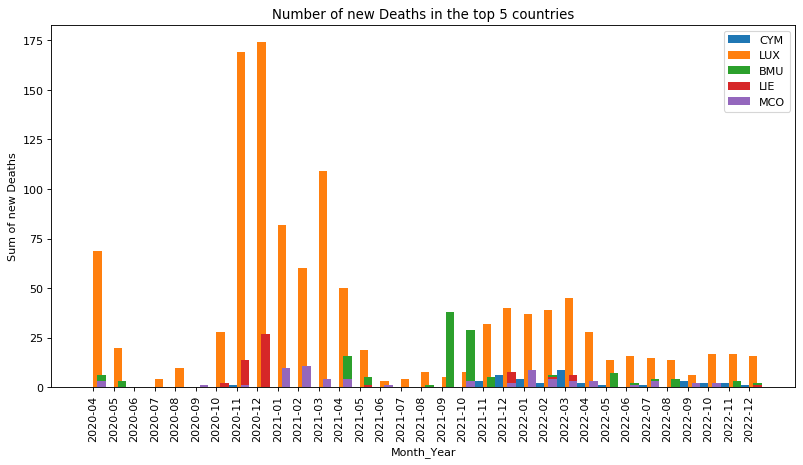

In [26]:

top_countries_data_deaths = top_countries_data_deaths.reset_index(drop=any)

labelx_dt = []
labelx_dt = top_countries_data_deaths["month_year"].unique()


country_1_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[0]),["sum_new_deaths"]]
country_2_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[1]),["sum_new_deaths"]]
country_3_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[2]),["sum_new_deaths"]]
country_4_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[3]),["sum_new_deaths"]]
country_5_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[4]),["sum_new_deaths"]]


country_1_top_sum_new_deaths = country_1_top_sum_new_deaths["sum_new_deaths"].to_list()
country_2_top_sum_new_deaths = country_2_top_sum_new_deaths["sum_new_deaths"].to_list()
country_3_top_sum_new_deaths = country_3_top_sum_new_deaths["sum_new_deaths"].to_list()
country_4_top_sum_new_deaths = country_4_top_sum_new_deaths["sum_new_deaths"].to_list()
country_5_top_sum_new_deaths = country_5_top_sum_new_deaths["sum_new_deaths"].to_list()

X_axis = np.arange(len(labelx_dt))
print(str(top_countries_selected[0]))

plt.figure(figsize=(12,6), dpi=80) 
plt.bar(X_axis - 0.2, country_1_top_sum_new_deaths, 0.4, label = top_countries_selected[0])
plt.bar(X_axis + 0.2, country_2_top_sum_new_deaths, 0.4, label = top_countries_selected[1])
plt.bar(X_axis + 0.4, country_3_top_sum_new_deaths, 0.4, label = top_countries_selected[2])
plt.bar(X_axis + 0.4, country_4_top_sum_new_deaths, 0.4, label = top_countries_selected[3])
plt.bar(X_axis + 0.4, country_5_top_sum_new_deaths, 0.4, label = top_countries_selected[4])
  
plt.xticks(X_axis, labelx)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Deaths")
plt.title("Number of new Deaths in the top 5 countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()



### Bottom 5 Countries - New Deaths

In [ ]:
bottom_countries_data_deaths = df_clean_data.loc[ (df_clean_data["iso_code"].isin(bottom_countries_selected)),
                                        # & (df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y')=="2020"),
                                        ["iso_code","month_year","sum_new_deaths"]]




# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
bottom_countries_data_deaths.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
bottom_countries_data_deaths.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
bottom_countries_data_deaths["month"] = bottom_countries_data_deaths["month"].astype("int64")
bottom_countries_data_deaths["year"] = bottom_countries_data_deaths["year"].astype("int64")

bottom_countries_data_deaths.reset_index(drop='Any',inplace=True)

bottom_countries_data_deaths =bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["month_year"]!= "2020-02") &
                                     (bottom_countries_data_deaths["month_year"]!= "2020-03") &
                                     (bottom_countries_data_deaths["year"]!= 2023)]


bottom_countries_data_deaths


BDI


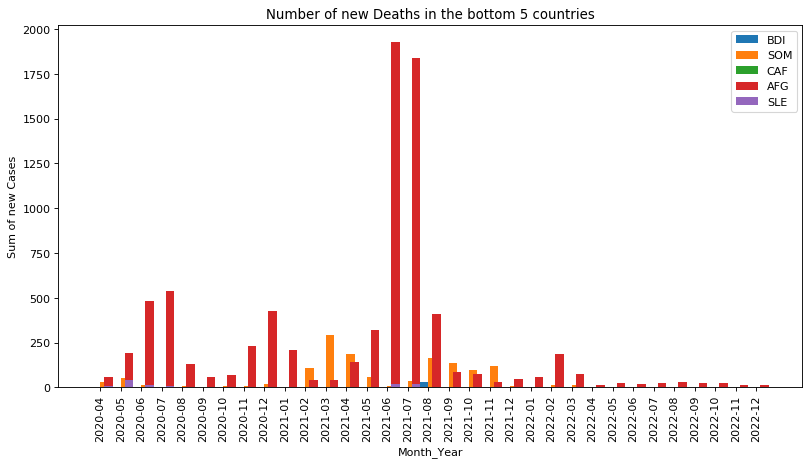

In [27]:
bottom_countries_data_deaths = bottom_countries_data_deaths.reset_index(drop=any)

labelx_bd = []
labelx_bd = bottom_countries_data_deaths["month_year"].unique()


country_1_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[0]),["sum_new_deaths"]]
country_2_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[1]),["sum_new_deaths"]]
country_3_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[2]),["sum_new_deaths"]]
country_4_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[3]),["sum_new_deaths"]]
country_5_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[4]),["sum_new_deaths"]]


country_1_bottom_sum_new_deaths = country_1_bottom_sum_new_deaths["sum_new_deaths"].to_list()
country_2_bottom_sum_new_deaths = country_2_bottom_sum_new_deaths["sum_new_deaths"].to_list()
country_3_bottom_sum_new_deaths = country_3_bottom_sum_new_deaths["sum_new_deaths"].to_list()
country_4_bottom_sum_new_deaths = country_4_bottom_sum_new_deaths["sum_new_deaths"].to_list()
country_5_bottom_sum_new_deaths = country_5_bottom_sum_new_deaths["sum_new_deaths"].to_list()

X_axis = np.arange(len(labelx_bd))
print(str(bottom_countries_selected[0]))

plt.figure(figsize=(12,6), dpi=80) 
plt.bar(X_axis - 0.2, country_1_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[0])
plt.bar(X_axis + 0.2, country_2_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[1])
plt.bar(X_axis + 0.4, country_3_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[2])
plt.bar(X_axis + 0.4, country_4_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[3])
plt.bar(X_axis + 0.4, country_5_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[4])
  
plt.xticks(X_axis, labelx_b)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Cases")
plt.title("Number of new Deaths in the bottom 5 countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()

